In [39]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
class GetMiniBatch:
    """
    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
    y : ndarray, shape (n_samples, 1)
    batch_size : int
    seed : int
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [41]:
class FC:
    """
    Parameters
    ----------
    n_nodes1 : int
    n_nodes2 : int
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, dropout_rate=0.5):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.W_feedback = 0
        self.B_feedback = 0
        self.dZ = 0
        self.dA = 0
        self.dropout_rate = dropout_rate
        self.mask = None
        self.input_X_forward = 0
        
    def forward(self, X):
        """
        Parameters
        ----------
        X : ndarray, shape (batch_size, n_nodes1)
        Returns
        ----------
        A : ndarray, shape (batch_size, n_nodes2)
        """ 
        self.input_X_forward = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
        
        
        dW = np.dot(self.input_X_forward.T, dA)
        dZ = np.dot(dA, self.W.T)
        self.dA = dA
        self.dW = dW
        self.dZ = dZ
        
        self.W_feedback = self.dW / self.dA.shape[0]
        self.B_feedback = np.average(self.dA, axis=0)
        
        self = self.optimizer.update(self)
        return dZ
    
    def dropout_forward(self, X, flag):
        if flag:
            self.mask = np.random.rand(*X.shape) > self.dropout_rate
            return X * self.mask
        else:
            return X * (1.0 - self.dropout_rate)
        
    def dropout_backward(self, X): 
        return X * self.mask

In [42]:
class Sigmoid:
 
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return 1 / (1 + np.exp(-1 * X))
    
    def _func_diff(self, X):
        return (1 - self._func(X)) * self._func(X)
        
    def forward(self, X):
       
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [43]:
class Tanh:

    def __init__(self):
        self.input_X_forward = 0
    
    def _func(self, X):
        return np.tanh(X)
    
    def _func_diff(self, X):
        return 1 - (self._func(X))**2
        
    def forward(self, X):

        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [44]:
class softmax:

    def __init__(self):
        # 初期化
        self.input_X_forward = 0
        self.pred = 0
    
    def _func(self, X):
        X = X - np.max(X)
        tmp = np.exp(X)
        denominator = np.sum(tmp, axis=1)
        output = tmp / denominator[:, np.newaxis]
        return output
    
    def _func_diff(self, X):
        return X
        
    def forward(self, X):
  
        self.input_X_forward = X
        A = self._func(X)
        self.pred = A
        return A
    
    def backward(self, dA):

        dZ = self.pred - dA
        
        return dZ

In [45]:
class SimpleInitializer:
  
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [46]:
class ReLU:

    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return np.maximum(0, X)
    
    def _func_diff(self, X):
        return np.where( x > 0, 1, 0)
        
    def forward(self, X):
       
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [47]:
class XavierInitializer:
    def __init__(self):
        self.n_prev_nodes = 1
        pass
        
    def W(self, n_nodes1, n_nodes2):
        self.n_prev_nodes = n_nodes1
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(1, n_nodes2) / np.sqrt(self.n_prev_nodes)
        return B

In [48]:
class HeInitializer:

    def __init__(self):
        self.n_prev_nodes = 1
        pass
        
    def W(self, n_nodes1, n_nodes2):
        self.n_prev_nodes = n_nodes1
        W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(1, n_nodes2) * np.sqrt(2 / self.n_prev_nodes)
        return B

In [49]:
class AdaGrad:
 
    def __init__(self, lr):
        self.lr = lr
        self.H_B = 1
        self.H_W = 1
    def update(self, layer):
            
        #dA, dWを更新＆保存
        self.H_B = self.H_B + np.average(layer.dA)**2
        self.H_W = self.H_W + np.average(layer.dW)**2
        
        layer.B = layer.B - self.lr * np.average(layer.dA, axis=0) / np.sqrt(self.H_B)
        layer.W = layer.W - self.lr * layer.dW / layer.dA.shape[0] / np.sqrt(self.H_W)
        
        return layer

In [50]:
class SGD:

    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.B = layer.B - self.lr * layer.B_feedback    
        layer.W = layer.W - self.lr * layer.W_feedback
        
        return layer

In [51]:
class SimpleConv1d():

    def __init__(self, n_input_hight, f_w, f_b, optimizer):
        DIM = 1
        
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.f_hight = len(f_w)
        self.n_input_hight = n_input_hight
        #self.n_input_width = n_input_width
        self.W = f_w[:, np.newaxis]
        self.B = f_b[:, np.newaxis]
        self.dZ = 0
        self.dA = 0
        self.dB = 0
        print("N_input:{} F_hight:{}".format(self.n_input_hight, self.f_hight))
        self.n_output_hight = self.n_input_hight - self.f_hight + 1
        #self.n_output_width = self.n_input_width - f_width +1
        self.input_X_forward = 0
        self.output_X_forward = np.zeros([self.n_output_hight, DIM])
        self.W_feedback = np.zeros([self.f_hight, DIM])
        self.B_feedback = 0
        self.Z_feedback = np.zeros([self.n_input_hight, DIM])
        
    def forward(self, X):
        
        self.input_X_forward = X
        for h in range(self.n_output_hight):
            h1 = h
            h2 = h + self.f_hight
            
            X_seg = X[h1:h2]
            self.output_X_forward[h] = np.dot(X_seg, self.W) + self.B
        
        return self.output_X_forward
    
    def backward(self, dA):
     
        dA = dA[:,np.newaxis]
        for i in range(self.f_hight):
            X_seg = self.input_X_forward[i : (i + self.n_output_hight)]
            X_seg = X_seg[:,np.newaxis]
            self.W_feedback[i] = np.dot(X_seg.T, dA)
        

        self.B_feedback = np.sum(dA, axis=0)

        dA_padding = np.zeros([self.f_hight-1, 1])
        dA = np.concatenate((dA, dA_padding), axis=0)
        dA = np.concatenate((dA_padding, dA), axis=0)
        for h in range(self.n_input_hight):
            h1 = h
            h2 = h + self.f_hight
            dA_seg = dA[h1:h2]

            dA_seg = np.fliplr(dA_seg.T).T
            self.Z_feedback[h] = np.dot(dA_seg.T, self.W)


        self = self.optimizer.update(self)
        return self.Z_feedback

In [52]:
def cal_output_size(n_feature_in, n_pading, n_filter, stride):
    return (n_feature_in + n_pading * 2 + n_filter) / stride

In [53]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

In [54]:
#initializer = SimpleInitializer()
optimizer = SGD(0.001)

In [55]:
scv = SimpleConv1d(len(x), w, b, optimizer)

N_input:4 F_hight:3


In [56]:
scv.forward(x)

array([[35.],
       [50.]])

In [57]:
delta_a = np.array([10, 20])

In [58]:
scv.backward(delta_a)

array([[ 30.],
       [110.],
       [170.],
       [140.]])

In [59]:
print("delta_b:",scv.B_feedback)
print("delta_w:",scv.W_feedback)
print("delta_x:",scv.Z_feedback)

delta_b: [30]
delta_w: [[ 50.]
 [ 80.]
 [110.]]
delta_x: [[ 30.]
 [110.]
 [170.]
 [140.]]


In [60]:
class Conv1d():
 
    def __init__(self, n_input_hight, f_w, f_b, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.f_hight = f_w.shape[2]
        self.n_input_hight = n_input_hight
        #self.n_input_width = n_input_width
        self.W = f_w
        self.B = f_b
        self.n_output_hight = self.n_input_hight - self.f_hight + 1
        self.input_X_forward = 0
        self.output_X_forward = np.zeros((self.W.shape[0], self.n_output_hight))
        self.W_feedback = np.zeros_like(self.W)
        self.B_feedback = np.zeros_like(self.B)
        self.Z_feedback = 0
    
    def forward(self, X):
            
        self.input_X_forward = X
        #for output_ch in range(self.W.shape[0]):
        A = np.zeros((self.n_output_hight, self.W.shape[0]))
        #self.input_X_forward = np.zeros((self.n_output_hight, X.shape[0], self.f_hight))
        for h in range(self.n_output_hight):
            h1 = h
            h2 = h + self.f_hight   
            X_seg = X[:, h1:h2]
            tmp = np.sum(X_seg * self.W, axis=1)
            A[h] = np.sum(tmp, axis=1)

        B = self.B[0]
        output = (A + B).T
        
        #print("output.shape:",output.shape)
        return output
    
    def backward(self, dA):
 
        X = np.tile(self.input_X_forward, (dA.shape[0] ,1))
        dL = np.zeros((X.shape[0], dA.shape[1]))
        
        for i in range(dA.shape[0]):
            o1 = i
            o2 = i + self.input_X_forward.shape[0]
            dL[o1:o2] = np.tile(dA[i], (self.input_X_forward.shape[0] ,1))
        

        loop = self.input_X_forward.shape[1] - dA.shape[1] + 1
        dW_tmp = np.zeros((X.shape[0], loop))
        for i in range(loop):
            i1 = i
            i2 = i + dA.shape[1]
            dX_seg = X[:, i1:i2]
            dW_tmp[:,i] = np.sum(dL * dX_seg, axis=1)
        

        for i in range(self.W.shape[0]):
            o1 = i
            o2 = i + self.W.shape[1]
            self.W_feedback[i] = dW_tmp[o1:o2]
        
        dB = np.sum(dA, axis=1)
        for i in range(self.B.shape[1]):
            self.B_feedback[:,i] = dB
        

        self.Z_feedback = np.zeros_like(self.input_X_forward)
        for i in range(dA.shape[0]):

            dA_padding = np.zeros([1, self.f_hight-1])
            dA_tmp = dA[i][np.newaxis,:]
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=1)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=1)
            dA_tmp = np.tile(dA_tmp, (self.input_X_forward.shape[0] ,1))
            dZ_seg = np.zeros_like(self.Z_feedback)
            
            for h in range(self.n_input_hight):
                h1 = h
                h2 = h + self.f_hight
                dA_seg = dA_tmp[:,h1:h2]
                dA_seg = np.fliplr(dA_seg.T).T
                dZ_seg[:,h] = np.sum(dA_seg * self.W[i], axis=1)
                
            self.Z_feedback += dZ_seg 
            
        self = self.optimizer.update(self)
        return self.Z_feedback

In [61]:
X = np.array([[1,2,3,4],[2,3,4,5]])
W = np.ones((3,2,3))
B = np.array([[[1,2,3], [1,2,3]]])

In [62]:
c = Conv1d(X.shape[1], W, B, None, optimizer)

In [63]:
c.forward(X)

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

In [64]:
dA = np.array([[2,4],[4,8],[6,12]])

In [65]:
c.backward(dA)

array([[12, 36, 36, 24],
       [12, 36, 36, 24]])

In [66]:
default_dnn_design = {
    'learning_rate':0.001,
    'total_layer':3,
    'func_layer1':'tanh',
    'func_layer2':'tanh',
    'func_layer3':'softmax',
    'node_layer0':786, 
    'node_layer1':400,
    'node_layer2':200,
    'node_layer3':10,
    'initializer':'SimpleInitializer',
    'initializer_sigma':0.05,
    'optimizer':'SGD',
}

class ScratchDeepNeuralNetrowkClassifier():

    
    def __init__(self, n_epoch, batch_size, verbose = False):
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_epoch = n_epoch
        self.loss = 0
        self.loss_val = 0
        self.activation_func = 0
        self.affine_func = 0
        self.n_layer = 0
        self.layer_instance = [0 for _ in range(64)]
  

    def _crossentropy(self, y_pred, y):

        INF_AVOIDANCE = 1e-8
        cross_entropy = -1 * y * np.log(y_pred + INF_AVOIDANCE)
        return np.sum(cross_entropy, axis=1)
    
    def add_layer(self, model):
        self.layer_instance[self.n_layer] = model
        self.n_layer += 1
        return
    
    def delet_all_layer(self):
        self.layer_instance[0:self.n_layer] = 0
        self.n_layer = 0
        
        return
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.loss = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        self.loss_val = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        
        i = 0
        get_mini_batch = GetMiniBatch(x_train, y_train, self.batch_size)
        for epoch in range(self.n_epoch):
            loop_count = 0
            sum_loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                X = mini_X_train
                #Forwardの計算
                for layer in range(self.n_layer):
                    X = self.layer_instance[layer].forward(X)
                
        
                sum_loss += self._crossentropy(X, mini_y_train)
                    
   
                dz = mini_y_train
                for layer in reversed(range(0, self.n_layer)):
                    dz = self.layer_instance[layer].backward(dz)
                
                loop_count += 1
                
            self.loss[i] = sum_loss / loop_count
            if X_val is not None and y_val is not None:
                y_val_pred = self._predict(X_val)
                self.loss_val[i] = self._crossentropy(y_val_pred, y_val)
                
            if self.verbose:
                print("Epoch:{} Loss:{} Loss(val):{}".format(i, self.loss[i], self.loss_val[i]))
                
            i +=1
            
        return
    
    def predict(self, X):
   
        for layer in range(self.n_layer):
            X = self.layer_instance[layer].forward(X)
        
        max_val = np.max(X, axis=1)
        mask = np.ones_like(X)
        X[X == max_val[:,np.newaxis]] = 1
        X[X != mask] = 0        
        
        return X

    def _predict(self, X):
        #Forwardの計算
        for layer in range(self.n_layer): 
            X = self.layer_instance[layer].forward(X)
        
        return X

In [67]:
class Flatten():
    
    def __init__(self):
        self.input_X_shape = 0
        
    def forward(self, X):
        self.inout_X_shape = X.shape
        return X.reshape(-1)[np.newaxis,:]
    
    def backward(self, X):
        output = X.reshape(self.inout_X_shape)
        return output

In [68]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_one_hot, test_size=0.95)
print(x_train.shape) # (48000, 784)
print(x_val.shape) # (12000, 784)

(3000, 784)
(57000, 784)


/tmp/ipykernel_15022/1027773539.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = x_train.astype(np.float)
/tmp/ipykernel_15022/1027773539.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = x_test.astype(np.float)
/home/lkhagvadorj/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarn

In [69]:
CNN = ScratchDeepNeuralNetrowkClassifier(1, 1)

In [70]:
f_w = np.ones((3,1,28))
f_b = np.array([[[1,1,1]]])

In [71]:
optimizer = SGD(0.01)
initializer = XavierInitializer()

In [72]:
CNN.add_layer(Conv1d(x_train.shape[1], f_w, f_b, initializer, optimizer))
CNN.add_layer(Flatten())
CNN.add_layer(FC(f_w.shape[0] * (x_train.shape[1] - f_w.shape[2] + 1), 100, initializer, optimizer))
CNN.add_layer(Sigmoid())
CNN.add_layer(FC(100, 10, initializer, optimizer))
CNN.add_layer(softmax())

In [73]:
CNN.fit(x_train, y_train, x_val, y_val)

/tmp/ipykernel_15022/185089456.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
/tmp/ipykernel_15022/3289879148.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-1 * X))


In [74]:
y_pred = CNN.predict(x_val)

/tmp/ipykernel_15022/3289879148.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-1 * X))


In [75]:
print("Pred=\n", y_pred)
print("Yval=\n", y_val[2])

Pred=
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Yval=
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [76]:
from sklearn.metrics import accuracy_score
print("Accuracy score={:.3f}".format(accuracy_score(y_pred[0], y_val[2])))

Accuracy score=0.800


In [77]:
class Conv1d():

    def __init__(self, n_input_hight, padding_size, f_w, f_b, initializer, optimizer):
        self.optimizer = optimizer

        self.f_hight = f_w.shape[2]
        self.padding_size = padding_size
        self.n_input_hight = n_input_hight + self.padding_size * 2

        self.W = f_w
        self.B = f_b
        self.n_output_hight = self.n_input_hight - self.f_hight + 1
        self.input_X_forward = 0
        self.output_X_forward = np.zeros((self.W.shape[0], self.n_output_hight))
        self.W_feedback = np.zeros_like(self.W)
        self.B_feedback = np.zeros_like(self.B)
        self.Z_feedback = 0
    
    def forward(self, X):
   
        
        #Padding
        X = np.pad(X, (self.padding_size, self.padding_size), 'constant', constant_values=(0, 0))
        
        self.input_X_forward = X
        A = np.zeros((self.n_output_hight, self.W.shape[0]))
        for h in range(self.n_output_hight):
            h1 = h
            h2 = h + self.f_hight   
            X_seg = X[:, h1:h2]
            tmp = np.sum(X_seg * self.W, axis=1)
            A[h] = np.sum(tmp, axis=1)

        B = self.B[0]
        output = (A + B).T
        
        return output
    
    def backward(self, dA):
        X = np.tile(self.input_X_forward, (dA.shape[0] ,1))
        dL = np.zeros((X.shape[0], dA.shape[1]))
        
        for i in range(dA.shape[0]):
            o1 = i
            o2 = i + self.input_X_forward.shape[0]
            dL[o1:o2] = np.tile(dA[i], (self.input_X_forward.shape[0] ,1))
        
        #入力の特徴量数 - 出力の特徴量数 +1
        loop = self.input_X_forward.shape[1] - dA.shape[1] + 1
        dW_tmp = np.zeros((X.shape[0], loop))
        for i in range(loop):
            i1 = i
            i2 = i + dA.shape[1]
            dX_seg = X[:, i1:i2]
            dW_tmp[:,i] = np.sum(dL * dX_seg, axis=1)
    
        for i in range(self.W.shape[0]):
            o1 = i
            o2 = i + self.W.shape[1]
            self.W_feedback[i] = dW_tmp[o1:o2]
        

        dB = np.sum(dA, axis=1)
        for i in range(self.B.shape[1]):
            self.B_feedback[:,i] = dB
        
        self.Z_feedback = np.zeros_like(self.input_X_forward)
        for i in range(dA.shape[0]):

            dA_padding = np.zeros([1, self.f_hight-1])
            dA_tmp = dA[i][np.newaxis,:]
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=1)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=1)
            dA_tmp = np.tile(dA_tmp, (self.input_X_forward.shape[0] ,1))
            dZ_seg = np.zeros_like(self.Z_feedback)
            
            for h in range(self.n_input_hight):
                h1 = h
                h2 = h + self.f_hight
                dA_seg = dA_tmp[:,h1:h2]
      
                dA_seg = np.fliplr(dA_seg.T).T
                dZ_seg[:,h] = np.sum(dA_seg * self.W[i], axis=1)
                
            self.Z_feedback += dZ_seg 

        self = self.optimizer.update(self)
        return self.Z_feedback

In [78]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)


x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])


x_train = x_train[:,np.newaxis,:]
x_test = x_test[:,np.newaxis,:]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_one_hot, test_size=0.95)
print(x_train.shape) 
print(x_val.shape) 

(3000, 1, 784)
(57000, 1, 784)


/tmp/ipykernel_15022/1041005328.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = x_train.astype(np.float)
/tmp/ipykernel_15022/1041005328.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = x_test.astype(np.float)
/home/lkhagvadorj/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWar

In [79]:
get_mini_batch = GetMiniBatch(x_train, y_train, 10)

/tmp/ipykernel_15022/185089456.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


In [80]:
mini_X_train, mini_y_train = get_mini_batch[0]

In [81]:
mini_X_train.shape

(10, 1, 784)

In [82]:
class Flatten():
    
    def __init__(self):
        self.input_X_shape = 0
        
    def forward(self, X):
        """
        X.shape (batch_size, n_input, n_feature1)
        
        return (batch_size, n_input * n_feature)
        """
        self.inout_X_shape = X.shape
        output = X.reshape([self.inout_X_shape[0], self.inout_X_shape[1] * self.inout_X_shape[2]])
        return output
    
    def backward(self, X):
        output = X.reshape(self.inout_X_shape)
        return output

In [83]:
A = np.array([[[1,2],[2,3]],[[4,5],[6,7]],[[8,9],[10,11]]])
A.shape

(3, 2, 2)

In [84]:
f = Flatten()

In [85]:
f.forward(A)

array([[ 1,  2,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [103]:
default_dnn_design = {
    'learning_rate':0.001,
    'total_layer':3,
    'func_layer1':'tanh',
    'func_layer2':'tanh',
    'func_layer3':'softmax',
    'node_layer0':786, 
    'node_layer1':400,
    'node_layer2':200,
    'node_layer3':10,
    'initializer':'SimpleInitializer',
    'initializer_sigma':0.05,
    'optimizer':'SGD',
}

class ScratchDeepNeuralNetrowkClassifier2():

    
    def __init__(self, n_epoch, batch_size, verbose = False):
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_epoch = n_epoch
        self.loss = 0
        self.loss_val = 0
        self.activation_func = 0
        self.affine_func = 0
        self.n_layer = 0
        self.layer_instance = [0 for _ in range(64)]

        
    def _crossentropy(self, y_pred, y):
        INF_AVOIDANCE = 1e-8
        cross_entropy = -1 * y * np.log(y_pred + INF_AVOIDANCE)
        return np.sum(cross_entropy, axis=1)
    
    def add_layer(self, model):
        self.layer_instance[self.n_layer] = model
        self.n_layer += 1
        return
    
    def delet_all_layer(self):
        self.layer_instance[0:self.n_layer] = 0
        self.n_layer = 0
        
        return
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.loss = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        self.loss_val = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        
        i = 0
        get_mini_batch = GetMiniBatch(x_train, y_train, self.batch_size)
        for epoch in range(self.n_epoch):
            loop_count = 0
            sum_loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                X = mini_X_train
                for layer in range(self.n_layer):
                    X = self.layer_instance[layer].forward(X)
              
                sum_loss += self._crossentropy(X, mini_y_train)
                    
                dz = mini_y_train
                for layer in reversed(range(0, self.n_layer)):
                    dz = self.layer_instance[layer].backward(dz)
        
                loop_count += 1
                
          
            self.loss[i] = sum_loss / loop_count
            if X_val is not None and y_val is not None:
                y_val_pred = self._predict(X_val)
                self.loss_val[i] = self._crossentropy(y_val_pred, y_val)
                
            if self.verbose:
                print("Epoch:{} Loss:{} Loss(val):{}".format(i, self.loss[i], self.loss_val[i]))
                
            i +=1
            
        return
    
    def predict(self, X):
        for layer in range(self.n_layer):
            X = self.layer_instance[layer].forward(X)
        
        max_val = np.max(X, axis=1)
        mask = np.ones_like(X)
        X[X == max_val[:,np.newaxis]] = 1
        X[X != mask] = 0        
        
        return X

    def _predict(self, X):
        for layer in range(self.n_layer):
            X = self.layer_instance[layer].forward(X)
        
        return X

In [104]:
class FC2:
  
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, dropout_rate=0.5):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.W_feedback = 0
        self.B_feedback = 0
        self.dZ = 0
        self.dA = 0
        self.dropout_rate = dropout_rate
        self.mask = None
        self.input_X_forward = 0
        
    def forward(self, X):
        self.input_X_forward = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
           
        dW = np.dot(self.input_X_forward.T, dA)
        dZ = np.dot(dA, self.W.T)
        self.dA = dA
        self.dW = dW
        self.dZ = dZ
        
        self.W_feedback = self.dW / self.dA.shape[0]
        self.B_feedback = np.average(self.dA, axis=0)

        self = self.optimizer.update(self)
        return dZ
    
    def dropout_forward(self, X, flag):
        if flag:
            self.mask = np.random.rand(*X.shape) > self.dropout_rate
            return X * self.mask
        else:
            return X * (1.0 - self.dropout_rate)
        
    def dropout_backward(self, X): 
        return X * self.mask

In [105]:
class Conv1d():

    def __init__(self, n_input_hight, f_w, f_b, initializer, optimizer):
        self.optimizer = optimizer
     
        self.n_input_hight = n_input_hight
        self.W = f_w    #(n_output, n_ch, f_size)
        self.B = f_b    #(1, n_ch, n_output)
        self.n_output = self.W.shape[0]
        self.n_input_ch = self.W.shape[1]
        self.f_hight = f_w.shape[2]
        self.n_output_hight = self.n_input_hight - self.f_hight + 1
        self.input_X_forward = 0
        self.output_X_forward = np.zeros((self.W.shape[0], self.n_output_hight))
        self.W_feedback = np.zeros_like(self.W)
        self.B_feedback = np.zeros_like(self.B)
        self.Z_feedback = 0
    
    def forward(self, X):
           
        self.input_X_forward = X
        batch_size = self.input_X_forward.shape[0]
        A = np.zeros((batch_size, self.n_output, self.n_input_ch, self.n_output_hight))
        B = self.B[0]
        B = B.T
        B = B[np.newaxis]
        X = X[:,np.newaxis]
        for h in range(self.n_output_hight):
            h1 = h
            h2 = h + self.f_hight
            X_seg = X[:,:,:,h1:h2]
            tmp = np.sum(X_seg * self.W, axis=3)
            tmp = tmp + B
            A[:,:,:,h] = tmp

        A = np.sum(A, axis=2)
        return A
    
    def backward(self, dA):
           
        batch_size = self.input_X_forward.shape[0]
        X = np.tile(self.input_X_forward, (dA.shape[1] ,1))
        dL = np.zeros((dA.shape[0], X.shape[1], dA.shape[2]))
        for i in range(self.n_output):
            o1 = i
            o2 = i + self.n_input_ch
            tmp = dA[:,i][:,np.newaxis,:]
            dL[:,o1:o2] = np.tile(tmp, (self.n_input_ch ,1))
        
        loop = self.n_input_hight - self.n_output_hight + 1
        dW_tmp = np.zeros((batch_size, self.n_output, loop))
        for i in range(loop):
            i1 = i
            i2 = i + self.n_output_hight
            dX_seg = X[:,:, i1:i2]
            dW_tmp[:,:,i] = np.sum(dL * dX_seg, axis=2)
        
        dW_tmp2 = np.average(dW_tmp, axis=0)     
        for i in range(dW_tmp2.shape[0]):
            o1 = i
            o2 = i + self.n_input_ch
            self.W_feedback[i] = dW_tmp2[o1:o2]


        dB = np.sum(dA, axis=2)
        dB = np.average(dB, axis=0) 
        for i in range(self.B.shape[1]):
            self.B_feedback[:,i] = dB
        
        self.Z_feedback = np.zeros_like(self.input_X_forward)
        for i in range(self.n_output):
            dA_padding = np.zeros([batch_size, 1, self.f_hight-1])
            dA_tmp = dA[:,i][:,np.newaxis,:]
            #print("dA_tmp.shape1:",dA_tmp.shape)
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=2)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=2)
            #print("dA_tmp.shape2:",dA_tmp.shape)
            dA_tmp = np.tile(dA_tmp, (self.n_input_ch ,1))
            dZ_seg = np.zeros_like(self.Z_feedback)
            
            for h in range(self.n_input_hight):
                h1 = h
                h2 = h + self.f_hight
                dA_seg = dA_tmp[:,:,h1:h2]
                dA_seg = np.fliplr(dA_seg.T).T
                dZ_seg[:,:,h] = np.sum(dA_seg * self.W[i], axis=2)
                
            self.Z_feedback += dZ_seg 

        self = self.optimizer.update(self)
        return self.Z_feedback

In [106]:
f_w = np.ones((1,1,28))
f_b = np.array([[[1]]])

In [107]:
CNN2 = Conv1d(x_train.shape[2], f_w, f_b, initializer, optimizer)

In [108]:
A = CNN2.forward(mini_X_train)

In [109]:
print(A.shape)

(10, 1, 757)


In [110]:
CNN2.backward(A)

array([[[1., 2., 3., ..., 3., 2., 1.]],

       [[1., 2., 3., ..., 3., 2., 1.]],

       [[1., 2., 3., ..., 3., 2., 1.]],

       ...,

       [[1., 2., 3., ..., 3., 2., 1.]],

       [[1., 2., 3., ..., 3., 2., 1.]],

       [[1., 2., 3., ..., 3., 2., 1.]]])

In [111]:
CNN2 = ScratchDeepNeuralNetrowkClassifier2(5, 10)

In [112]:
CNN2.add_layer(Conv1d(x_train.shape[2], f_w, f_b, initializer, optimizer))
CNN2.add_layer(Flatten())
CNN2.add_layer(FC2(f_w.shape[0] * (x_train.shape[2] - f_w.shape[2] + 1), 100, initializer, optimizer))
CNN2.add_layer(Sigmoid())
CNN2.add_layer(FC2(100, 10, initializer, optimizer))
CNN2.add_layer(softmax())

In [119]:
CNN2.fit(x_train, y_train, x_val, y_val)

/tmp/ipykernel_15022/185089456.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


In [120]:
y_pred = CNN2.predict(x_val)

In [121]:
print("Pred=\n", y_pred)
print("Yval=\n", y_val)

Pred=
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yval=
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [122]:
from sklearn.metrics import accuracy_score
print("Accuracy score={:.3f}".format(accuracy_score(y_pred, y_val)))

Accuracy score=0.716


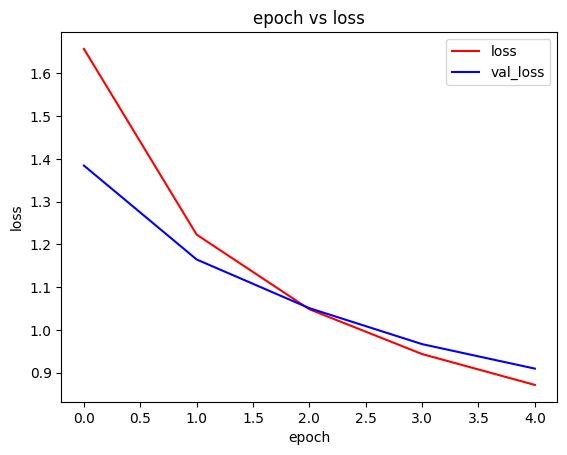

In [123]:
loss = np.array(CNN2.loss)
loss_ave = np.average(loss, axis=1)

loss_val = np.array(CNN2.loss_val)
loss_val_ave = np.average(loss_val, axis=1)

plt.title("epoch vs loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_ave, "r", label="loss")
plt.plot(loss_val_ave, "b", label="val_loss")
plt.legend()
plt.show()

In [101]:
A = np.zeros([10,757])
B = np.zeros([10,100])
print(A.shape, B.shape)

(10, 757) (10, 100)


In [102]:
C = np.dot(A.T, B)
C.shape

(757, 100)